<div class="cite2c-biblio"></div><div class="cite2c-biblio"></div><div class="cite2c-biblio"></div>Choosing a good set of hyperparameters is one of most important steps but also pretty much annoying and time consuming. The small number of hyperparameters may allow you to find an optimal hyperparameters after a few trials. This is, however, not the case for complex models like neural network. Tuning complex models requires to tune hyperparameters efficiently and algorithmically. Tuning models algorithmically is one of the hot topics in machine learning space, which is called. Many frameworks and algorithms[paper](https://cyphe.rs/static/atm.pdf), [paper](https://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf) have been suggested. In this blog post, we will go through the most basic three algorithms: grid, random, and Bayesian search.

# Background
When optimizing hyperparameters, information available is mostly only score value of defined metrics(e.g., accuracy for classification) with respect to each set of hyperparameters. We query a set of hyperparameters and get a score value as a response. Optimization algorithm mainly aims for making efficient queries and find an optimal set as soon as possible without knowing how objective function looks like. This kind of optimization problem is called balck-box optimization. Black-box optimization is defined as the following:

> "Black Box" optimization refers to a problem setup in which an optimization algorithm is supposed to optimize (e.g., minimize) an objective function through a so-called black-box interface: the algorithm may query the value f(x) for a point x, but it does not obtain gradient information, and in particular it cannot make any assumptions on the analytic form of f (e.g., being linear or quadratic). We think of such an objective function as being wrapped in a black-box. The goal of optimization is to find an as good as possible value f(x) within a predefined time, often defined by the number of available queries to the black box. Problems of this type regularly appear in practice, e.g., when optimizing parameters of a model that is either in fact hidden in a black box (e.g., a third party software library) or just too complex to be modeled explicitly.

> by [Balck-Box Optimization Competition homepage](https://bbcomp.ini.rub.de/).

\* There are some hyperparameter optimization methods to make use of gradient information, e.g., [paper1](http://proceedings.mlr.press/v37/maclaurin15.pdf).

Three algorithms, grid, random, and Bayesian search are three of basic algorithms of black-box optimization. They have the following characteristics:
 

### Grid Search
Grid search is the simplest method. First, we place finite number of test points to test on each hyperparameter axis and then make grid test points by combining them. Here is the example:
```python
A: (1e-8, 1e-6, 1e-4)
B: (0, 1)
(A, B): [(1e-8, 0), (1e-8, 1), (1e-6, 0) (1e-6, 1) (1e-4, 0) (1e-4, 1)]
```
When you have only a few hyperparameters, this method may works. Once dimension increases, the number of trials blows up exponentially.


### Random Search
Random search is known effective over high dimensional search space. Especially when we have small subsets of effective hyperparameters out of high dimensional space, we search these important parameters effectively. [paper](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).


### Bayesian search
While random search samples points independently, Bayesian search samples promising points more effectively by utilizing historical results. We first use GP (Gaussian process) to build estimation function, which takes parameters and spits out score estimation. Fitting GP is, of course, based on historical results.

GP also outputs variance along with mean. If this variance is large, small mean does not necessary imply optimal because high values also likely happen as well as small values. Points minimizing mean of estimation function are not necessary optimal. Thus, we need to define metric to consider trade off between mean and variance. 

Functions of this kind of metrics are called acquisition function. One of the most commonly used function is _Expected Improvement_. Here is the definition:
$$  a_{EI}(x; \{x_n,  y_n\}, \theta) = \left.E[max(f(x_{best}) - f(x), 0) \right| \{x_n,  y_n\}, \theta]$$
where $f(\cdot)$ is score function; $\{x_n,  y_n\}$ historical input and its response from score function not acquisition function; $\theta$ is parameters of Gaussian process; $E[\cdot]$ is taking expectation with respect to a Gaussian probability.


The right hand can be calculated analytically to the following form:
$$a_{EI}(x; \{x_n,  y_n\}, \theta) = \sigma(x ;  \{x_n,  y_n\}, \theta) [\gamma(x) \Phi(\gamma(x)) + N (\gamma(x); 0, 1)]$$
where
$$\gamma(x) = \frac{f(x_{best}) − \mu(x ; \{x_n,  y_n\}, \theta)}{\sigma(x ;  \{x_n,  y_n\}, \theta)}$$
$N(\cdot; 0, 1)$ and $\Phi(\cdot)$ are p.d.f. and c.d.f of Gaussian distribution, respectively.

Here is python code:
```python
import numpy as np

def expected_improvement(x, model, evaluated_loss, jitter=0.01):
    """ expected_improvement
    Expected improvement acquisition function.

    Note
    ----
    This implementation aims for minimization

    Parameters:
    ----------
    x: array-like, shape = (n_hyperparams,)
    model: GaussianProcessRegressor object.
        Gaussian process trained on previously evaluated hyperparameters.
    evaluated_loss: array-like(float), shape = (# historical results,).
         the values of the loss function for the previously evaluated
         hyperparameters.
    jitter: float
        positive value to make the acquisition more explorative.
    """
    x = np.atleast_2d(x)
    mu, var = model.predict(x)
    # Consider 1d case
    sigma = np.sqrt(var)[0, 0]
    mu = mu[0, 0]
    # Avoid too small sigma
    if sigma == 0.:
        return 0.
    else:
        loss_optimum = np.min(evaluated_loss)
        gamma = (loss_optimum - mu - jitter) / sigma
        ei_val = sigma * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        return ei_val
```

Summing up the above discussion, Bayesian optimization is executed in the following steps:
1. Sample a few points and score them.
2. Initialize GP with sampled points
3. Sample points that minimize acquisition function
4. Score sampled points and store the results in GP
5. Iterate 3. and 4.

Here are python codes for the step 3. and 4.:

Step 3.
```python
def _bayes_sample(self, num_restarts=25):
    init_xs = self._random_sample(num_restarts)
    # Define search space 
    bounds = self.design_space.get_bounds()
    # Historical results
    evaluated_loss = self._y
    ys = []
    xs = []

    # Find a point to minimize acquisition function
    for x0 in init_xs:
        res = minimize(fun=-self.acquisition_func,
                       x0=x0,
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(self.model, evaluated_loss))
        ys.append(-res.fun)
        xs.append(res.x)
    idx = np.argmax(ys)
    best_x = np.array(xs)[idx]
    return best_x

def _random_sample(self, num_samples):
    Xs = []
    for i in range(num_samples):
        x = random_sample(self.params_conf)
        Xs.append(x)
    return list(Xs)
```

Step 4.
```python
def _update(self, eps=1e-6):
    X, y = self.data
    y = np.array(y)[:, None]
    # Update data in GP
    self.model.set_XY(X_vec, y)
    # Update hyperparameters of GP
    self.model.optimize()
```
`self.model.optimize()` optimize GP model defined at [GPy](https://github.com/SheffieldML/GPy). One of the benefits of using GPy over scikit-learn implementation is GPy allows you to optimize hyperparmeteres of GP models. To make it easy to understand the above code, I change some parts. If you want to see the full implementation, check out [this repository](https://github.com/jjakimoto/BBOptimizer).

In [12]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt



data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=5,
                                   n_redundant=5)


def score_func(params):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    train_idx, test_idx = list(splitter.split(data, target))[0]
    train_data = data[train_idx]
    train_target = target[train_idx]
    clf = SVC(**params)
    clf.fit(train_data, train_target)
    
    pred = clf.predict(data[test_idx])
    true_y = target[test_idx]
    score = accuracy_score(true_y, pred)
    return -score

params_conf = [
    {'name': 'C', 'domain': (1e-8, 1e5), 'type': 'continuous', 'scale': 'log'},
    {'name': 'gamma', 'domain': (1e-8, 1e5), 'type': 'continuous', 'scale': 'log'},
    {'name': 'kernel', 'domain': 'rbf', 'type': 'fixed'}
]


map_func = dict(linear=lambda x: x, square=lambda x: x, sin=np.sin)


def score_func(x):
    print("x", x)
    # score = np.sin(x["x2_1"]) * map_func[x["x3"]](x["x1"]) * map_func[x["x3"]](x["x2_2"])
    score = x["x2_1"] + (x["x1"])**2
    score_val = -score
    print("score_val", score_val)
    return score_val


params_conf = [
    {"name": "x1", "domain": (.1, 5), "type": "continuous",
     "num_grid": 5, "scale": "log"},
    {"name": "x2", "domain": (-5, 5), "type": "continuous",
     "num_grid": 5, "dimensionality": 2},
]

In [4]:
from hedgeable_ai.optimizer.tuner import BayesOptimizer
opt = BayesOptimizer(score_func, params_conf)
opt.search(num_iter=20)

x {'x1': 0.2720987871491608, 'x2_1': 1.7174245650245563, 'x2_2': 3.2721953538439053}
score_val -36.82771670299085
x {'x1': 1.0729166285379201, 'x2_1': 1.3393386240312113, 'x2_2': -4.554134763502583}
score_val 91.96291954317623
x {'x1': 3.175416404101055, 'x2_1': 2.085337275744294, 'x2_2': 4.834595929958198}
score_val -125.16915374953254
x {'x1': 3.878213384832875, 'x2_1': -3.173177686484835, 'x2_2': -2.17069040444138}
score_val -1.6392921320154166
x {'x1': 0.38587426075678244, 'x2_1': -0.06772867187542086, 'x2_2': 1.5029494629804923}
score_val -3.4761183210092823
x {'x1': 5, 'x2_1': 2.7574326868617196, 'x2_2': 5.0}
score_val -152.7574326868617
x {'x1': 5, 'x2_1': 5.0, 'x2_2': 5.0}
score_val -155.0
x {'x1': 5, 'x2_1': -5.0, 'x2_2': 5.0}
score_val -145.0
x {'x1': 5, 'x2_1': 5.0, 'x2_2': 5.0}
score_val -155.0
x {'x1': 0.1, 'x2_1': -5.0, 'x2_2': 5.0}
score_val -120.01
x {'x1': 5, 'x2_1': 3.860420781823435, 'x2_2': 5.0}
score_val -153.86042078182345
x {'x1': 5, 'x2_1': -5.0, 'x2_2': 2.67758

({'x1': 5, 'x2_1': 5.0, 'x2_2': 5.0}, -155.0)

In [13]:
from bboptimizer import Optimizer

opt = Optimizer(score_func, params_conf, sampler="bayes", r_min=5)
opt.search(num_iter=10)

  0%|          | 0/10 [00:00<?, ?it/s]

x {'x1': 0.2530803796536886, 'x2_1': -2.3295022558974123, 'x2_2': 4.325622271375826}
score_val 2.2654525773317573
x {'x1': 1.8170253172518358, 'x2_1': 4.9423867953582175, 'x2_2': -0.9333236075514932}
score_val -8.243967798892353
x {'x1': 0.5147915988731556, 'x2_1': 0.3296110754544834, 'x2_2': -1.7793405931410522}
score_val -0.5946214657248634
x {'x1': 1.3906244579467453, 'x2_1': -4.079507237297836, 'x2_2': 4.41841012227693}
score_val 2.1456708542581566
x {'x1': 0.18256397738260496, 'x2_1': -3.4508942198800696, 'x2_2': 2.948363929151548}
score_val 3.4175646140423135
x {'x1': 0.1, 'x2_1': 5.0, 'x2_2': 5.0}
score_val -5.01


 60%|██████    | 6/10 [00:00<00:00, 23.89it/s]

x {'x1': 5, 'x2_1': 5.0, 'x2_2': 5.0}
score_val -30.0


 70%|███████   | 7/10 [00:00<00:00, 12.90it/s]

x {'x1': 5, 'x2_1': -5.0, 'x2_2': -3.493136044310482}
score_val -20.0


 80%|████████  | 8/10 [00:00<00:00, 10.38it/s]

x {'x1': 3.030993429299334, 'x2_1': 4.878777263222592, 'x2_2': 3.7592037994282013}
score_val -14.065698431678328


 90%|█████████ | 9/10 [00:00<00:00,  8.75it/s]

x {'x1': 4.180127120432536, 'x2_1': 3.972503984769141, 'x2_2': 1.6393038895316279}
score_val -21.445966727744743


100%|██████████| 10/10 [00:00<00:00,  7.67it/s]


({'x1': 5, 'x2_1': 5.0, 'x2_2': 5.0}, -30.0)

In [14]:
m = opt.sampler.model
m.predict(m.X)

(array([[ 1.02757693],
        [ 0.08181919],
        [ 0.77019477],
        [ 1.01679758],
        [ 1.13125708],
        [ 0.37284858],
        [-1.87603691],
        [-0.97612287],
        [-0.44208651],
        [-1.10624783]]), array([[1.22000027e-08],
        [1.22000045e-08],
        [1.22000062e-08],
        [1.22000027e-08],
        [1.22000045e-08],
        [1.22000062e-08],
        [1.21999991e-08],
        [1.22000062e-08],
        [1.21999920e-08],
        [1.21999689e-08]]))

In [15]:
import numpy as np
scores = opt.sampler.data[1]
bayes_min_scores = [np.min(scores[:i]) for i in range(1, len(scores) + 1)]

In [16]:
opt = Optimizer(score_func, params_conf, sampler="random")
opt.search(num_iter=10)

  0%|          | 0/10 [00:00<?, ?it/s]

x {'x1': 0.22197751066789448, 'x2_1': -2.6186422057753167, 'x2_2': -0.3707326959737536}
score_val 2.5693681905330017
x {'x1': 0.3663109176567124, 'x2_1': -0.7463313137613126, 'x2_2': 3.593191238617637}
score_val 0.6121476253668098
x {'x1': 0.12766212622408138, 'x2_1': -4.3976672115227355, 'x2_2': 1.991633886248934}
score_val 4.381369593050683
x {'x1': 2.2779476413249213, 'x2_1': -2.918231955869759, 'x2_2': 0.23825658251600323}
score_val -2.2708135007480132
x {'x1': 3.0639801246066596, 'x2_1': -4.729342892302122, 'x2_2': -0.41025525767307425}
score_val -4.658631311682519
x {'x1': 2.4329494989340823, 'x2_1': 3.3292024739217947, 'x2_2': 2.097947698317718}
score_val -9.248445738285398
x {'x1': 0.8882512998237474, 'x2_1': 4.309099621134871, 'x2_2': -2.33746153747463}
score_val -5.098089992773448
x {'x1': 0.1863907702907347, 'x2_1': -1.4573228354514045, 'x2_2': -0.3950943038369008}
score_val 1.422581316201831
x {'x1': 0.38500687301312875, 'x2_1': -2.3217340566924527, 'x2_2': -0.6831922955081

 90%|█████████ | 9/10 [00:00<00:00, 86.74it/s]

x {'x1': 0.13250820937695323, 'x2_1': -3.9792051390713556, 'x2_2': 0.8134449134700041}
score_val 3.961646713519069


100%|██████████| 10/10 [00:00<00:00, 88.57it/s]


({'x1': 2.4329494989340823,
  'x2_1': 3.3292024739217947,
  'x2_2': 2.097947698317718},
 -9.248445738285398)

In [65]:
import numpy as np
scores = opt.sampler.data[1]
random_min_scores = [np.min(scores[:i]) for i in range(1, len(scores) + 1)]

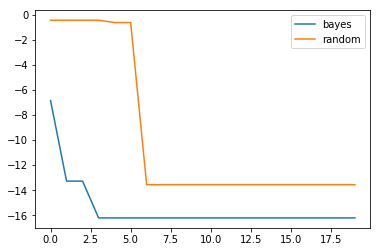

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(bayes_min_scores, label="bayes")
plt.plot(random_min_scores, label="random")
plt.legend()

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit


def score_func(params):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    train_idx, test_idx = list(splitter.split(data, target))[0]
    train_data = data[train_idx]
    train_target = target[train_idx]
    clf = SVC(probability=True, **params)
    clf.fit(train_data, train_target)
    
    pred = clf.predict_proba(data[test_idx])[:, 1]
    true_y = target[test_idx]
    score = roc_auc_score(true_y, pred)
    return score

You can also put the [link URL][1] below the current paragraph
like [this][2].


[1]: http://url
[2]: http://another.url "A funky title"

In [1]:
import tensorflow as tf


mnist = tf.contrib.learn.datasets.load_dataset("mnist")

/home/tomoaki/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/tomoaki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np


train = mnist.train
X = train.images
train_X = X
train_y = np.expand_dims(train.labels, -1)
train_y = OneHotEncoder().fit_transform(train_y)

valid = mnist.validation
X = valid.images
valid_X = X 
valid_y = np.expand_dims(valid.labels, -1)
valid_y = OneHotEncoder().fit_transform(valid_y)

test = mnist.test
X = test.images
test_X = X
test_y = test.labels

For the sake of the simplicity, we are going to use the following six parameters:

- the number of layers
- the number of hidden units
- learning rate
- weight regularizer
- optimization algorithm

In [3]:
from bboptimizer import Optimizer
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import Activation, Reshape
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras.regularizers import l1, l2


def get_optimzier(name, **kwargs):
    if name == "rmsprop":
        return RMSprop(**kwargs)
    elif name == "adam":
        return Adam(**kwargs)
    elif name == "sgd":
        return SGD(**kwargs)
    elif name == "adadelta":
        return Adadelta(**kwargs)
    else:
        raise ValueError(name)


def construct_NN(params):
    model = Sequential()
    model.add(Reshape((784,), input_shape=(784,)))
    
    def update_model(_model, _params, name):
        _model.add(Dropout(_params[name + "_drop_rate"]))
        _model.add(Dense(units=_params[name + "_num_units"],
                    activation=None,
                    kernel_regularizer=l2(_params[name + "_w_reg"])))
        if _params[name + "_is_batch"]:
            _model.add(BatchNormalization())
        if _params[name + "_activation"] is not None:
            _model.add(Activation(_params[name + "_activation"]))
        return _model
    
    # Add input layer    
    model = update_model(model, params, "input")
    # Add hidden layer
    for i in range(params["num_hidden_layers"]):
        model = update_model(model, params, "hidden")
    # Add output layer
    model = update_model(model, params, "output")
    optimizer = get_optimzier(params["optimizer"],
                              lr=params["learning_rate"])
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
        

def score_func(params):
    print("parameters", params)
    model = construct_NN(params)
    model.fit(train_X[:100], train_y[:100],
              epochs=params["epochs"],
              batch_size=params["batch_size"], verbose=1)
    print("###################", model.metrics_names)
    score = model.evaluate(valid_X, valid_y,
                  batch_size=params["batch_size"])
    idx = model.metrics_names.index("acc")
    score = score[idx]
    return score

params_conf = [
    {"name": "num_hidden_layers", "type": "integer",
     "domain": (0, 5)},
    {"name": "batch_size", "type": "integer",
     "domain": (16, 128), "scale": "log"},
    {"name": "learning_rate", "type": "continuous",
     "domain": (1e-5, 1e-1), "scale": "log"},
    {"name": "epochs", "type": "fixed",
     "domain": 1, "scale": "log"},
    {"name": "optimizer", "type": "categorical",
     "domain": ("rmsprop", "sgd", "adam", "adadelta")},
    
    {"name": "input_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "input_num_units", "type": "integer",
     "domain": (32, 256), "scale": "log"},
    {"name": "input_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "input_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "input_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "hidden_drop_rate", "type": "continuous",
     "domain": (0, 0.75)},
    {"name": "hidden_num_units", "type": "integer",
     "domain": (32, 256), "scale": "log"},
    {"name": "hidden_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "hidden_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "hidden_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "output_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "output_num_units", "type": "fixed",
     "domain": 10},
    {"name": "output_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "output_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "output_activation", "type": "fixed",
     "domain": "softmax"},
    
]

Using TensorFlow backend.


In [4]:
opt = Optimizer(score_func, params_conf, sampler="bayes", r_min=3)
opt.search(num_iter=30)

parameters {'num_hidden_layers': 0, 'batch_size': 18, 'learning_rate': 0.02057215503477297, 'optimizer': 'sgd', 'input_drop_rate': 0.03844025116936911, 'input_num_units': 202, 'input_w_reg': 3.5808757936861503e-07, 'input_is_batch': True, 'input_activation': 'sigmoid', 'hidden_drop_rate': 0.5791737833287955, 'hidden_num_units': 58, 'hidden_w_reg': 3.7529559038143463e-07, 'hidden_is_batch': True, 'hidden_activation': 'sigmoid', 'output_drop_rate': 0.024272432143737976, 'output_w_reg': 0.004675130137714763, 'output_is_batch': True, 'epochs': 1, 'output_num_units': 10, 'output_activation': 'softmax'}
Epoch 1/1
100/100 [==============================] - 1s 7ms/step - loss: 2.2705 - acc: 0.2500
################### ['loss', 'acc']
5000/5000 [==============================] - 0s 63us/step
parameters {'num_hidden_layers': 5, 'batch_size': 26, 'learning_rate': 6.966866303033105e-05, 'optimizer': 'sgd', 'input_drop_rate': 0.4251144281950014, 'input_num_units': 85, 'input_w_reg': 3.25005813892813

 /home/tomoaki/anaconda3/lib/python3.6/site-packages/bboptimizer-0.1.2-py3.6.egg/bboptimizer/samplers/utils.py:92: RuntimeWarning:invalid value encountered in sqrt


parameters {'num_hidden_layers': 5, 'batch_size': 61, 'learning_rate': 2.373304256858395e-05, 'optimizer': 'sgd', 'input_drop_rate': 0.22913877308114927, 'input_num_units': 117, 'input_w_reg': 0.0013633667639281202, 'input_is_batch': True, 'input_activation': 'relu', 'hidden_drop_rate': 0.1615080895308683, 'hidden_num_units': 57, 'hidden_w_reg': 4.50381385019084e-08, 'hidden_is_batch': True, 'hidden_activation': 'relu', 'output_drop_rate': 0.23194190489355665, 'output_w_reg': 0.0013899983512799898, 'output_is_batch': False, 'epochs': 1, 'output_num_units': 10, 'output_activation': 'softmax'}
Epoch 1/1
100/100 [==============================] - 1s 9ms/step - loss: 2.9786 - acc: 0.1100
################### ['loss', 'acc']
5000/5000 [==============================] - 0s 38us/step
parameters {'num_hidden_layers': 3, 'batch_size': 79, 'learning_rate': 0.002774672822325474, 'optimizer': 'rmsprop', 'input_drop_rate': 0.38104462725240884, 'input_num_units': 237, 'input_w_reg': 2.454129110601023

Epoch 1/1
100/100 [==============================] - 1s 6ms/step - loss: 3.9536 - acc: 0.1200
################### ['loss', 'acc']
5000/5000 [==============================] - 0s 45us/step
parameters {'num_hidden_layers': 0, 'batch_size': 90, 'learning_rate': 1.1119889345947554e-05, 'optimizer': 'adam', 'input_drop_rate': 0.3408337345797058, 'input_num_units': 40, 'input_w_reg': 3.422728559694684e-09, 'input_is_batch': False, 'input_activation': 'relu', 'hidden_drop_rate': 0.27521397801320147, 'hidden_num_units': 173, 'hidden_w_reg': 7.222197235806796e-05, 'hidden_is_batch': True, 'hidden_activation': 'sigmoid', 'output_drop_rate': 0.2452223312864802, 'output_w_reg': 1.7462221865508668e-09, 'output_is_batch': True, 'epochs': 1, 'output_num_units': 10, 'output_activation': 'softmax'}
Epoch 1/1
100/100 [==============================] - 1s 6ms/step - loss: 2.7485 - acc: 0.0800
################### ['loss', 'acc']
5000/5000 [==============================] - 0s 15us/step
parameters {'num_hi

Epoch 1/1
100/100 [==============================] - 1s 6ms/step - loss: 2.6769 - acc: 0.0500
################### ['loss', 'acc']
5000/5000 [==============================] - 0s 48us/step
parameters {'num_hidden_layers': 5, 'batch_size': 25, 'learning_rate': 0.002788912702877285, 'optimizer': 'adadelta', 'input_drop_rate': 0.360190173435404, 'input_num_units': 82, 'input_w_reg': 3.2293141693007388e-09, 'input_is_batch': True, 'input_activation': 'tanh', 'hidden_drop_rate': 0.5763797162549921, 'hidden_num_units': 128, 'hidden_w_reg': 4.0129130956066055e-10, 'hidden_is_batch': True, 'hidden_activation': 'sigmoid', 'output_drop_rate': 0.4317874634405411, 'output_w_reg': 0.000937518311302301, 'output_is_batch': True, 'epochs': 1, 'output_num_units': 10, 'output_activation': 'softmax'}
Epoch 1/1
100/100 [==============================] - 1s 11ms/step - loss: 2.6109 - acc: 0.1400
################### ['loss', 'acc']
5000/5000 [==============================] - 0s 76us/step


({'batch_size': 26,
  'epochs': 1,
  'hidden_activation': 'tanh',
  'hidden_drop_rate': 0.15384393458113038,
  'hidden_is_batch': True,
  'hidden_num_units': 190,
  'hidden_w_reg': 0.0016561624348636547,
  'input_activation': 'relu',
  'input_drop_rate': 0.4251144281950014,
  'input_is_batch': True,
  'input_num_units': 85,
  'input_w_reg': 3.2500581389281373e-07,
  'learning_rate': 6.966866303033105e-05,
  'num_hidden_layers': 5,
  'optimizer': 'sgd',
  'output_activation': 'softmax',
  'output_drop_rate': 0.3107043536117049,
  'output_is_batch': False,
  'output_num_units': 10,
  'output_w_reg': 0.030531142401088746},
 0.07580000195205211)

In [1]:
from bboptimizer.samplers.utils import SAMPLERS_MAP
SAMPLERS_MAP

{'bayes': bboptimizer.samplers.bayes.BayesSampler,
 'grid': bboptimizer.samplers.grid.GridSampler,
 'random': bboptimizer.samplers.random.RandomSampler}

In [6]:
opt.optimizer.

AttributeError: 'BayesOptimizer' object has no attribute 'optimizert'

In [13]:
%pylab inline
import GPy
import GPyOpt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [49]:
def myf(x):
    print(x)
    return sum((2*x)**2)

bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)},
         {'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)}]

# bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)}]

In [50]:
max_iter = 15
opt = GPyOpt.methods.BayesianOptimization(myf,bounds)
opt.run_optimization(max_iter, verbosity=True)

[[ 0.83472294 -0.35045541]]
[[-0.81677674 -0.20893279]]
[[0.56892437 0.98436479]]
[[-0.70499574  0.15934302]]
[[ 0.36236546 -0.37212878]]
[[ 0.3276707 -0.3794702]]
[[ 0.19993882 -0.76537162]]
[[ 0.16673283 -0.17536047]]
[[-2.46435936e-02 -7.75201312e-05]]
[[-1.  1.]]
[[0.05523789 0.08312356]]
[[-0.0745971  0.0846349]]
[[-0.13251386 -0.12509652]]
[[-0.0692017   0.49375632]]
[[-0.99652227 -0.99553451]]
[[-0.28496292 -0.90985205]]
[[0.12828897 0.05891816]]
[[0.47730358 0.37926197]]
[[-0.58558844 -0.02097188]]
[[-0.67679943  0.899019  ]]


In [38]:
print(opt.X)
print(opt.x_opt)

[[ 9.87769699e-01 -5.22068678e-01]
 [-2.60640122e-01 -5.92168000e-01]
 [ 3.62671315e-01  3.08434924e-01]
 [ 4.23333810e-01 -5.07602750e-01]
 [ 6.87402157e-01  2.10656733e-01]
 [ 3.12278334e-01  1.83631054e-01]
 [ 8.31197264e-04  5.77286352e-02]
 [-1.00000000e+00  9.75483572e-01]
 [ 6.73192012e-02 -9.58554176e-02]
 [-1.00000000e+00 -1.00000000e+00]
 [-6.75609333e-02 -3.06036996e-02]
 [ 1.39019074e-02 -7.44473136e-04]
 [-9.62346335e-01 -2.63916597e-02]
 [ 9.52792460e-01  9.90318356e-01]
 [ 3.20600327e-01 -3.70925950e-01]
 [ 8.19614846e-01 -5.49740227e-01]
 [ 1.98597971e-02 -4.48193390e-01]
 [ 8.05345803e-01  7.37027584e-01]
 [-4.62028321e-01  4.55104405e-01]
 [-7.58883852e-01  1.00326861e-02]]
[ 0.01390191 -0.00074447]


In [56]:
opt.Y - np.sum((2 * opt.X) ** 2, axis=-1, keepdims=True)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [55]:
opt.X.shape

(20, 2)

In [29]:
opt.Y_best

array([6.61410245e-01, 7.33240385e-02, 7.33240385e-02, 7.33240385e-02,
       7.33240385e-02, 4.15628331e-04, 4.15628331e-04, 4.15628331e-04,
       4.15628331e-04, 4.15628331e-04, 4.15628331e-04, 4.15628331e-04,
       4.15628331e-04, 4.15628331e-04, 4.15628331e-04, 4.15628331e-04,
       4.15628331e-04, 4.15628331e-04, 4.15628331e-04, 4.15628331e-04])

In [35]:
if [3]:
    print("hey")

hey


In [19]:
import numpy as np
np.array(None)

array(None, dtype=object)

In [14]:
x.get('scale', None)

'log'

In [6]:
import math
math.log10(2)

0.3010299956639812

In [5]:
1e-5

1e-05

In [1]:
from hedgeable_ai.optimizer.tuner import RandomOptimizer


mixed_domain =[{'name': 'var1', 'type': 'continuous', 'domain': (-5,5),'dimensionality': 3},
               {'name': 'var3', 'type': 'discrete', 'domain': (3,8,10),'dimensionality': 2},
               {'name': 'var4', 'type': 'categorical', 'domain': ('hey', 'what up', 'oops'),'dimensionality': 1},
               {'name': 'var5', 'type': 'integer', 'domain': (1, 10), 'scale':'log'}]

opt = RandomOptimizer(score_func=lambda x: x, params_conf=mixed_domain)

/home/tom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


{'name': 'var1', 'type': 'continuous', 'domain': (-5, 5), 'dimensionality': 3}
3
{'name': 'var3', 'type': 'discrete', 'domain': (3, 8, 10), 'dimensionality': 2}
2
{'name': 'var4', 'type': 'categorical', 'domain': ('hey', 'what up', 'oops'), 'dimensionality': 1}
1
{'name': 'var5', 'type': 'integer', 'domain': (1, 10), 'scale': 'log'}
1


In [2]:
x = [0., 0., 0., 8., 1., 1., 0., 0., 1.]
param = opt.vec2params(x)

[0.0, 0.0, 0.0, 8, 3, 'hey', 10]


In [3]:
param

{'var1_1': 0.0,
 'var1_2': 0.0,
 'var1_3': 0.0,
 'var3_1': 8,
 'var3_2': 3,
 'var4_1': 'hey',
 'var5': 10}

In [4]:
opt.params2vec(param)

array([0., 0., 0., 8., 3., 1., 0., 0., 1.])

In [5]:
opt.design_space.dimensionality

7

In [6]:
opt.design_space.model_dimensionality

9

In [1]:
conf = dict()
conf.get("hey", False)

False

In [1]:
from bboptimizer.samplers import RandomSampler, GridSampler

params_conf = [
    {"name": "num_hidden_layers", "type": "integer",
     "domain": (0, 5)},
    {"name": "batch_size", "type": "integer",
     "domain": (16, 128), "scale": "log"},
    {"name": "learning_rate", "type": "continuous",
     "domain": (1e-5, 1e-1), "scale": "log"},
    {"name": "epochs", "type": "fixed",
     "domain": 1, "scale": "log"},
    {"name": "optimizer", "type": "categorical",
     "domain": ("rmsprop", "sgd", "adam", "adadelta")},
    
    {"name": "input_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "input_num_units", "type": "integer",
     "domain": (32, 256), "scale": "log"},
    {"name": "input_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "input_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "input_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "hidden_drop_rate", "type": "continuous",
     "domain": (0, 0.75)},
    {"name": "hidden_num_units", "type": "integer",
     "domain": (32, 256), "scale": "log"},
    {"name": "hidden_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "hidden_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "hidden_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "output_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "output_num_units", "type": "fixed",
     "domain": 10},
    {"name": "output_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "output_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "output_activation", "type": "fixed",
     "domain": "softmax"},
    
]
sampler = RandomSampler(params_conf)
sampler = GridSampler(params_conf)

In [2]:
sampler.sample(1000)

[{'batch_size': 16,
  'epochs': 1,
  'hidden_activation': 'relu',
  'hidden_drop_rate': 0,
  'hidden_is_batch': True,
  'hidden_num_units': 32,
  'hidden_w_reg': 1e-10,
  'input_activation': 'relu',
  'input_drop_rate': 0,
  'input_is_batch': True,
  'input_num_units': 32,
  'input_w_reg': 1e-10,
  'learning_rate': 1e-05,
  'num_hidden_layers': 0,
  'optimizer': 'rmsprop',
  'output_activation': 'softmax',
  'output_drop_rate': 0,
  'output_is_batch': True,
  'output_num_units': 10,
  'output_w_reg': 1e-10},
 {'batch_size': 16,
  'epochs': 1,
  'hidden_activation': 'relu',
  'hidden_drop_rate': 0,
  'hidden_is_batch': True,
  'hidden_num_units': 32,
  'hidden_w_reg': 1e-10,
  'input_activation': 'relu',
  'input_drop_rate': 0,
  'input_is_batch': True,
  'input_num_units': 32,
  'input_w_reg': 1e-10,
  'learning_rate': 1e-05,
  'num_hidden_layers': 0,
  'optimizer': 'rmsprop',
  'output_activation': 'softmax',
  'output_drop_rate': 0,
  'output_is_batch': False,
  'output_num_units': 1

In [47]:
sampler.design_space.get_bounds()def _update(self, new_X, new_y):
        raise NotImplementedError()

[(0, 5),
 (1.2041199826559248, 2.1072099696478683),
 (-5.0, -1.0),
 1,
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0, 0.5),
 (1.505149978319906, 2.4082399653118496),
 (-10.0, -1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0, 0.75),
 (1.505149978319906, 2.4082399653118496),
 (-10.0, -1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0, 0.5),
 10,
 (-10.0, -1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 'softmax']

In [9]:
import GPy

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [10]:
import numpy as np

X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

In [12]:
m = GPy.models.GPRegression(X,Y, kernel)

In [13]:
m.optimize()

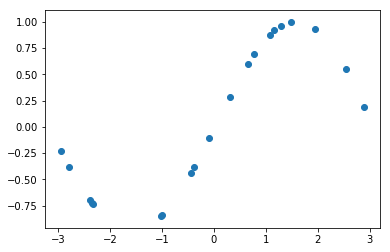

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X, m.predict(X)[0])

 /home/tomoaki/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


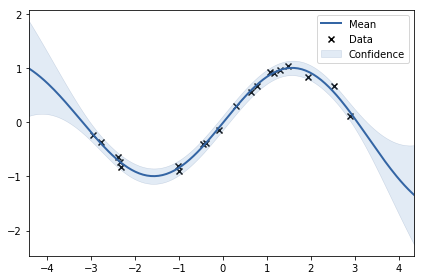

In [15]:
m.plot()

In [19]:
np.array(m.Y)

array([[-0.36317103],
       [-0.90006156],
       [-0.22539455],
       [ 0.84372948],
       [ 0.67132079],
       [ 0.9049409 ],
       [ 0.29535432],
       [-0.79765234],
       [ 0.67060782],
       [ 0.95756316],
       [ 0.56646489],
       [-0.40472252],
       [-0.63471063],
       [ 1.04614911],
       [ 0.11785994],
       [-0.73412533],
       [-0.81908068],
       [ 0.93348404],
       [-0.13794554],
       [-0.37600229]])

In [22]:
m.optimize()

 /home/tom/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


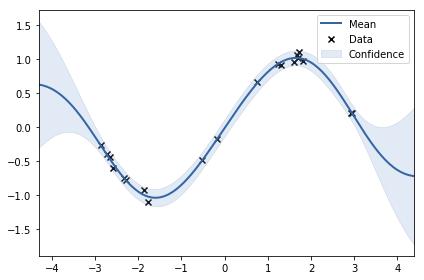

In [23]:
m.plot()

In [45]:
mu, var = m.predict(X[0])

AssertionError: need at least column vectors as inputs to kernels for now, given X2.shape=(1,)

In [46]:
X[0]

array([-2.64953963])

In [42]:
mu[idx] = 1e-2

In [43]:
mu

array([[0.01      ],
       [0.01      ],
       [0.93153356],
       [1.00190278],
       [0.95576666],
       [1.01372503],
       [1.01406936],
       [0.01      ],
       [0.01      ],
       [1.01161006],
       [0.6489535 ],
       [0.01      ],
       [0.01      ],
       [0.01      ],
       [0.2150561 ],
       [0.22010886],
       [0.01      ],
       [1.01455512],
       [0.01      ],
       [0.01      ]])

In [30]:
min_f(mu)

TypeError: '>' not supported between instances of 'float' and 'vectorize'

In [51]:
np.var(np.random.randn(1))

0.0